# Quantum Operation Transposing

It is impossible for a quantum cirtuit to perform transposing which transforms a completely unknown unitary gate U into its transpose U^T.
But, if non-unit probability in a quantum circuit is allowed, the quantum time flip can realize the transposing.
This article shows an example of transposing by the quantum time flip.

Reference:
- Giulio Chiribella and Zixuan Liu, "Quantum operations with indefinite time direction."

In [1]:
# import
import numpy as np
import itertools
from math import pi
import matplotlib.pyplot as plt

#%matplotlib inline

from qiskit import (
    QuantumCircuit,
    ClassicalRegister,
    QuantumRegister,
    execute,
    BasicAer,
    Aer,
    transpile,
    assemble,
)
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.circuit.library import YGate, ZGate, SGate

print("Imports Successful")


Imports Successful


In [2]:
def calc_theta(p):
    return 2 * np.arccos(np.sqrt(p))


def fill_result(result):
    bit_len = len(list(result.keys())[0])
    bit = ["0", "1"]
    key_list = ["".join(bits) for bits in itertools.product(bit, repeat=bit_len)]

    total = sum(result.values())
    result_new = {}
    for k in key_list:
        v = result.get(k)
        result_new[k] = 0 if v is None else v / total
    return result_new


def count_result(result, filter_str):
    bit_list = []
    for bit_str in filter_str:
        if bit_str == "0" or bit_str == "1":
            bit_list.append([bit_str])
        else:
            bit_list.append(["0", "1"])
    key_list = ["".join(bits) for bits in itertools.product(*bit_list)]

    total = 0
    for k in key_list:
        total += result[k]

    return total


In [3]:
# Calculate probability where post-measurement state corresponds to bits.
def calcP(statevec, bits, with_statevec=False):
    proj = None
    for bit in bits:
        if bit==0:
            qb = Statevector([1, 0]).to_operator()
        elif bit==1:
            qb = Statevector([0, 1]).to_operator()
        else:
            qb = Operator([[1, 0], [0, 1]])
        proj = qb if proj is None else proj.tensor(qb)
    measure = statevec.evolve(proj)
    p = measure.inner(measure)
    if with_statevec:
        return p, measure
    else:
        return p

# Calculate post-measurement state.
def statevec_cond(statevec, bits):
    qargs = [n for n, v in enumerate(reversed(bits)) if v is not None]
    return partial_trace(statevec, qargs)

# Calculate probability and post-measurement state.
def statevec_mean_cond(statevector, bits):
    p, measure = calcP(statevector, bits, with_statevec=True)
    densitymatrix = statevec_cond(partial_trace(measure, []), bits)
    return p, densitymatrix/p

# Calculate probability and post-measurement state by sampling.
def statevec_mean_cond_sample(res, bits):
    nbit = len([v for v in bits if v is None])
    densitymatrix = None
    for bit in range(nbit):
        qb = Operator([[0, 0], [0, 0]])
        densitymatrix = qb if densitymatrix is None else densitymatrix.tensor(qb)
    count = 0
    for statevector in res:
        p = abs(calcP(statevector, bits))
        if p > 1 - 0.000000001:
            densitymatrix += statevec_cond(statevector, bits)
            count += 1
    return count*1.0/len(res), densitymatrix/count if count > 0 else None

In [4]:
# Quantum time flip
def qtimeflip_g(qc, f, measure_flag=True):    
    qc.barrier()
    qc.h(1)
    qc.cx(1, 2)
    f(qc, 2)
    qc.fredkin(3, 1, 2)
    qc.cx(0, 1)
    qc.h(0)
    if measure_flag:
        qc.measure(0, 0)
        qc.measure(1, 1)
    qc.barrier()
    return qc

# Test circuit
def qtf_test_qc(control_x, p_i, p_f, p_i2=pi/2, p_f2=pi/2, measure_flag=True, qs_measure_flag=True):  
    theta_i, phi_i, lmd_i = p_i, p_i2, p_i2
    theta_f, phi_f, lmd_f = p_f, p_f2, p_f2
    def ini(qc, q):
        qc.u(theta_i, phi_i, lmd_i, q)
        
    def f(qc, q):
        qc.u(theta_f, phi_f, lmd_f, q)

    def inv_ini(qc, q):
        qc.u(-theta_i, -lmd_i, -phi_i, q)

    def inv_transpose_f(qc, q):
        qc.u(theta_f, -lmd_f, -phi_f, q)

    def inv_f(qc, q):
        qc.u(-theta_f, -lmd_f, -phi_f, q)
        
    # Initialize
    qc = QuantumCircuit(4, 3)
    if control_x == 1: # quantum time flip conrtol
        qc.x(3)
    ini(qc, 0)
    # quantum time flip
    qtimeflip_g(qc, f, measure_flag=qs_measure_flag)
    # reverse
    if control_x == 1:
        inv_transpose_f(qc, 2)
    else:
        inv_f(qc, 2)
    inv_ini(qc, 2)
    if measure_flag:
        qc.measure(2, 2)
    return qc

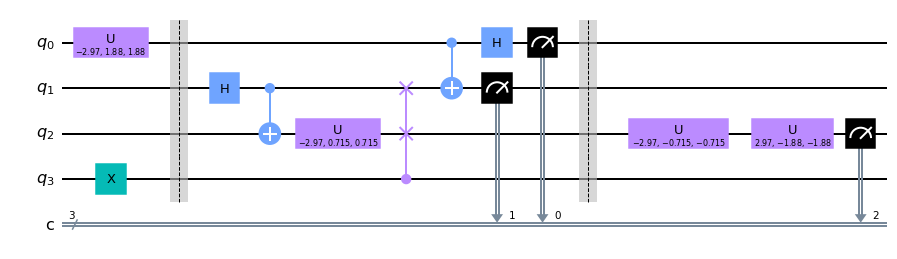

In [5]:
# This example produces a test circuit of quantum time flip with a control qubit q3, input q0, output q2 and an operator f.
# q0 and q1 are used for quantum teleportation.
# This circuit prepares the state of q0 by using an unitary operation (ini).
# And, this circuit performs the following operations to output q2 of the quantum time flip.
# - inverted operation of f^T if the control qubit is 1 or inverted operation of f if the control qubit is 0.
# - inverted operation of ini.
# Therefore, the final state of q2 becomes |0> if the quantum time flip finishes successfully.
control_x = 1
p_i, p_f = tuple((np.random.rand(2)-0.5)*2*pi)
p_i2, p_f2 = tuple((np.random.rand(2)-0.5)*2*pi)
qc = qtf_test_qc(control_x, p_i, p_f, p_i2=p_i2, p_f2=p_f2, measure_flag=True, qs_measure_flag=True)
qc.draw(output="mpl")

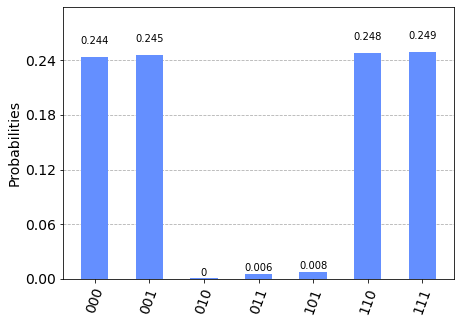

In [6]:
# The quantum time flip measures output q0 and q1 of quantum teleportation
# and obtains one of four possible classical results. (00, 01, 10 and 11)
# If (q1, q0) = (0, 0), the quantum time flip successfully finishes.
# This result shows that,
# - the probability that (q2, q1, q0) becomes (0, 0, 0) is about 0.25.
# - the probability that (q2, q1, q0) becomes (1, 0, 0) is 0.
# It means that the probability that (q1, q0) becomes (0, 0) is about 0.25, q2 = |0>,
# and the quantum time flip finishes successfully
aer_sim = Aer.get_backend("aer_simulator")
job = aer_sim.run(assemble(qc), shots=4096)
result = job.result().get_counts()
plot_histogram(result)

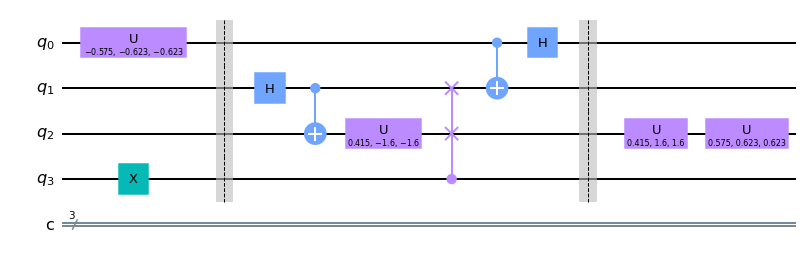

In [7]:
# Another simulation.
# This example calculates the density matrix of the state.
# To calculate the density matrix, the recipient skips the measurement of the state.
control_x = 1
p_i, p_f = tuple((np.random.rand(2)-0.5)*2*pi)
p_i2, p_f2 = tuple((np.random.rand(2)-0.5)*2*pi)
qc = qtf_test_qc(control_x, p_i, p_f, p_i2=p_i2, p_f2=p_f2, measure_flag=False, qs_measure_flag=False)
qc.draw(output="mpl")

In [8]:
# The quantum time flip measures output q0 and q1 of quantum teleportation
# and obtains one of four possible classical results. (00, 01, 10 and 11)
sv_simulator = Aer.get_backend('statevector_simulator')
circuit = transpile(qc, backend=sv_simulator)
statevector = sv_simulator.run(circuit).result().data()['statevector']

In [9]:
# This result shows q2 = |0> if (q2, q1) = (0, 0). q3 is fixed to |1>.
# As a result, the quantum time flip successfully finishes if (q2, q1) = (0, 0).
statevec_mean_cond(statevector, [control_x, None, 0, 0])

((0.2500000000000001+0j),
 DensityMatrix([[1.00000000e+00+0.00000000e+00j,
                 1.07552856e-16-2.22044605e-16j],
                [1.07552856e-16+2.22044605e-16j,
                 6.08714233e-32+0.00000000e+00j]],
               dims=(2,)))